In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
df = pd.read_csv('file.csv', parse_dates=['timestamp'])

In [36]:
df.head()

,timestamp,motor_id,temp,vibration,current,line_speed,coil_thickness,failure,RUL
0,01-01-2023 00:00,M01,70.747267,0.061319,16.166984,113.686765,0.47,0,620
1,01-01-2023 01:00,M01,74.987420,0.047820,15.388805,120.237161,0.32,0,619
2,01-01-2023 02:00,M01,77.957081,0.036182,16.905429,104.893980,0.55,0,618
3,01-01-2023 03:00,M01,72.621209,0.030295,15.192753,94.686036,0.62,0,617
4,01-01-2023 04:00,M01,73.125986,0.054397,15.842673,111.554094,0.37,0,616


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       50000 non-null  object 
 1   motor_id        50000 non-null  object 
 2   temp            50000 non-null  float64
 3   vibration       50000 non-null  float64
 4   current         50000 non-null  float64
 5   line_speed      50000 non-null  float64
 6   coil_thickness  50000 non-null  float64
 7   failure         50000 non-null  int64  
 8   RUL             50000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 3.4+ MB


In [38]:
df.describe()

,temp,vibration,current,line_speed,coil_thickness,failure,RUL
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,72.325601,0.041869,14.604719,107.461652,0.519939,0.003000,279.311060
std,3.846375,0.014066,1.551187,10.273275,0.180074,0.054691,273.232823
min,62.463167,0.006663,10.517250,58.360903,0.280000,0.000000,0.000000
25%,69.526957,0.031363,13.508116,100.503531,0.370000,0.000000,69.000000
50%,72.178555,0.040694,14.499551,108.093752,0.520000,0.000000,197.000000
75%,75.150264,0.051814,15.654051,115.120320,0.620000,0.000000,412.000000
max,83.010249,0.081123,19.756628,138.417576,1.370000,1.000000,1443.000000


In [39]:
#plt.plot(df['timestamp'], df['vibration'])

In [40]:
#normalizing the data
from sklearn.preprocessing import MinMaxScaler
sensors = df.iloc[:,2:7]
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(sensors))
df1 = pd.DataFrame(df1, columns=sensors.columns)
df1['timestamp'] = df['timestamp']
df1['failure'] = df['failure']
df1['RUL'] = df['RUL']
df1['motor_id'] = df['motor_id']
df1.head()

,temp,vibration,current,line_speed,coil_thickness,timestamp,failure,RUL,motor_id
0,0.403176,0.734031,0.611484,0.691084,0.174312,01-01-2023 00:00,0,620,M01
1,0.609539,0.552736,0.527260,0.772906,0.036697,01-01-2023 01:00,0,619,M01
2,0.754069,0.396441,0.691408,0.581252,0.247706,01-01-2023 02:00,0,618,M01
3,0.494379,0.317368,0.506041,0.453743,0.311927,01-01-2023 03:00,0,617,M01
4,0.518946,0.641063,0.576383,0.664444,0.082569,01-01-2023 04:00,0,616,M01


In [41]:
#train-test split giving 65% of each motors data to train and rest to test
train_l = []
test_l = []
for id in df1['motor_id'].unique():
    df2 = df1[df1['motor_id']== id]
    train_size = int(len(df2)*0.65)
    train_l.append(df2.iloc[:train_size])
    test_l.append(df2.iloc[train_size: ])
train = pd.concat(train_l).reset_index(drop=True)
test = pd.concat(test_l).reset_index(drop=True)

In [42]:
train.sample(5)

,temp,vibration,current,line_speed,coil_thickness,timestamp,failure,RUL,motor_id
24641,0.442223,0.264799,0.364569,0.385965,0.541284,03-08-2023 05:00,0,259,M04
8360,0.238612,0.452519,0.544389,0.506393,0.266055,19-03-2023 12:00,0,270,M02
11399,0.556758,0.517596,0.797329,0.622515,0.220183,24-07-2023 03:00,0,30,M02
24473,0.362518,0.192568,0.086015,0.538301,0.311927,27-07-2023 05:00,0,427,M04
18835,0.071384,0.281415,0.147924,0.477152,0.220183,01-09-2023 03:00,0,486,M03


In [43]:
#creating time series dataset bcz LSTM need sequence as input
def create_dataset(data, time_step = 1):
    X, y_failure, y_RUL = [],[],[]
    group_data = data.groupby('motor_id')
    for motor_id, motor_data in group_data:
        X_data = data.iloc[:,0:5].values
        failure = data.iloc[:,6].values
        RUL = data.iloc[:,7].values
        for i in range(len(data)-time_step):
            a = X_data[i:i+time_step]
            X.append(a)
            y_failure.append(failure[i+time_step])
            y_RUL.append(RUL[i+time_step])
    return np.array(X), np.array(y_failure), np.array(y_RUL)

time_step = 24
X_train, y_train_failure, y_train_RUL = create_dataset(train, time_step)
X_test, y_test_failure, y_test_RUL = create_dataset(test, time_step)

In [44]:
np.shape(X_train)

(162380, 24, 5)

In [45]:
X_train.shape, X_test.shape

((162380, 24, 5), (87380, 24, 5))

In [46]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [47]:
#building the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(32)(x)
x = Dropout(0.2)(x)

failure = Dense(1, activation='sigmoid', name='failure')(x)
rul = Dense(1, activation='linear', name='rul')(x)

model = Model(inputs=input_layer, outputs=[failure, rul])

In [48]:
model.compile(
              optimizer='adam',
              loss={'failure': 'binary_crossentropy', 'rul': 'mean_squared_error'},
              loss_weights = {'failure': 10.0, 'rul': 0.1}
              )

In [49]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 64)    │     17,920 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 24, 64)    │     33,024 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 64)    │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 32)        │     12,416 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ failure (Dense)     │ (None, 1)         │         33 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rul (Dense)         │ (None, 1)         │         33 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,426 (247.76 KB)

 Trainable params: 63,426 (247.76 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
from sklearn.preprocessing import MinMaxScaler

rul_scaler = MinMaxScaler()
y_train_RULs = rul_scaler.fit_transform(y_train_RUL.reshape(-1, 1))
y_test_RULs = rul_scaler.transform(y_test_RUL.reshape(-1, 1))
y_train_RULs = y_train_RULs.flatten()
y_test_RULs = y_test_RULs.flatten()
print("y_train_RULs shape (after flatten):", y_train_RULs.shape)

y_train_RULs shape (after flatten): (162380,)


In [51]:
history = model.fit(
    X_train,
    {'failure': y_train_failure, 'rul': y_train_RULs},
    epochs=10,
    batch_size=48,
    validation_data=(X_test, {'failure': y_test_failure, 'rul': y_test_RULs})
)

Epoch 1/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 200s 57ms/step - failure_loss: 0.0272 - loss: 0.2810 - rul_loss: 0.0860 - val_failure_loss: 0.0220 - val_loss: 0.2230 - val_rul_loss: 0.0277
Epoch 2/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 202s 57ms/step - failure_loss: 0.0198 - loss: 0.2026 - rul_loss: 0.0408 - val_failure_loss: 0.0221 - val_loss: 0.2243 - val_rul_loss: 0.0359
Epoch 3/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 201s 57ms/step - failure_loss: 0.0197 - loss: 0.2006 - rul_loss: 0.0399 - val_failure_loss: 0.0214 - val_loss: 0.2167 - val_rul_loss: 0.0280
Epoch 4/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 203s 57ms/step - failure_loss: 0.0201 - loss: 0.2051 - rul_loss: 0.0363 - val_failure_loss: 0.0201 - val_loss: 0.2039 - val_rul_loss: 0.0308
Epoch 5/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 188s 53ms/step - failure_loss: 0.0178 - loss: 0.1812 - rul_loss: 0.0317 - val_failure_loss: 0.0197 - val_loss: 0.2015 - val_rul_loss: 0.0451
Epoch 6/10
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 193s 57ms/step - failure_loss: 0.0187 - los

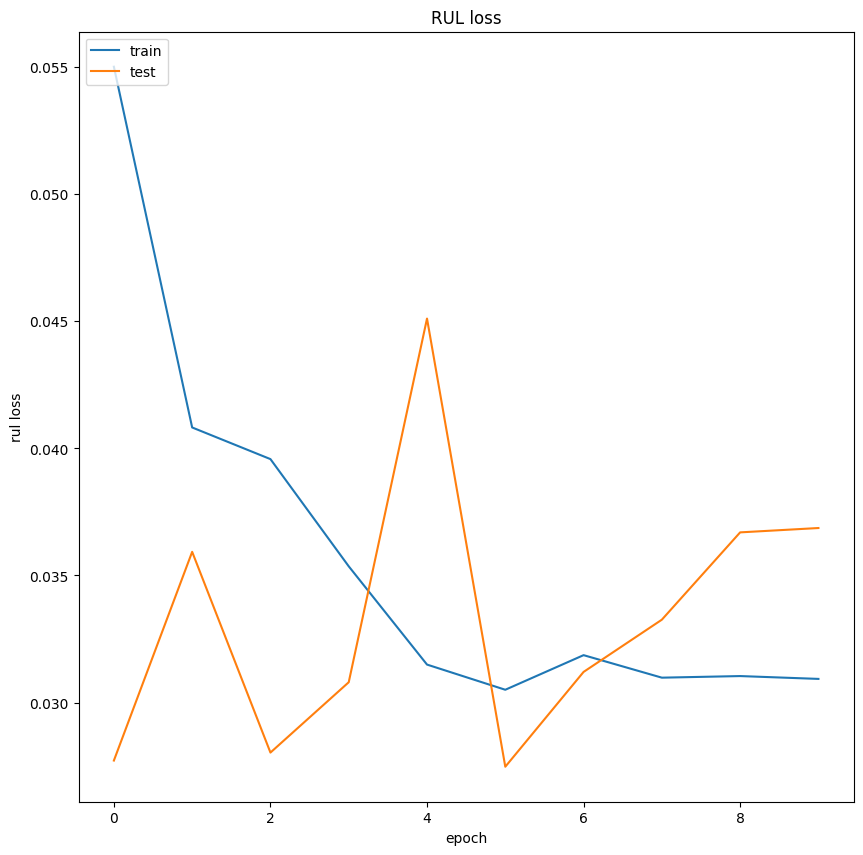

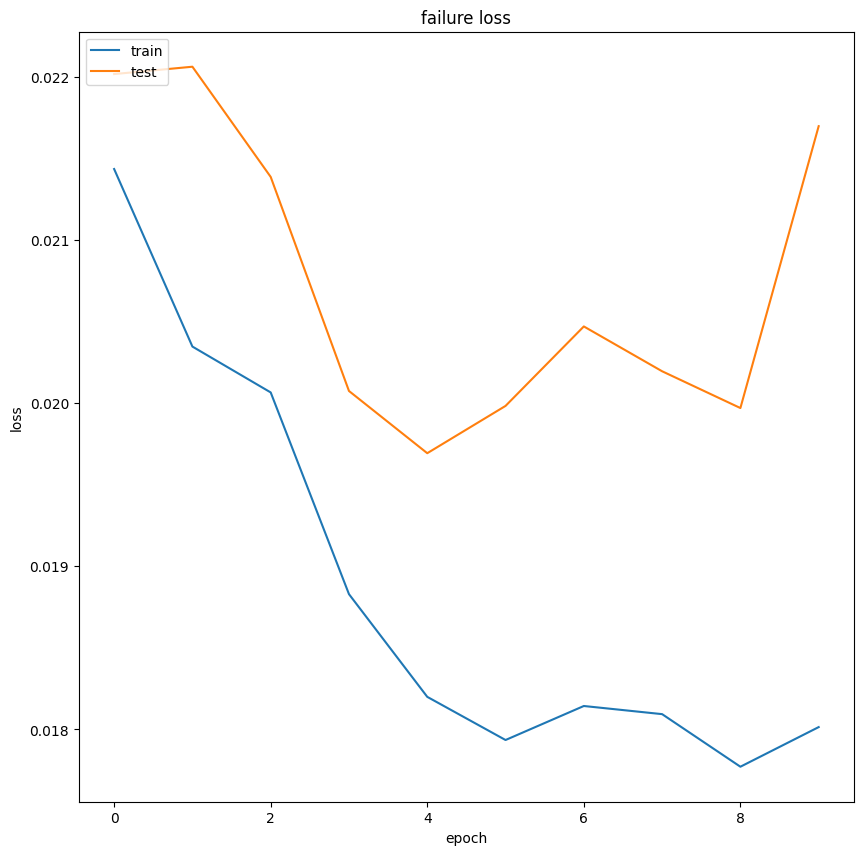

In [52]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['rul_loss'])
plt.plot(history.history['val_rul_loss'])
plt.title('RUL loss')
plt.ylabel('rul loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['failure_loss'])
plt.plot(history.history['val_failure_loss'])
plt.title('failure loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_loss.png")

In [53]:
train_p_fail, train_p_RUL = model.predict(X_train)
test_p_fail, test_p_RUL = model.predict(X_test)

5075/5075 ━━━━━━━━━━━━━━━━━━━━ 60s 12ms/step
2731/2731 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step


In [ ]:
train_p_RUL = rul_scaler.inverse_transform(train_p_RUL)
test_p_RUL = rul_scaler.inverse_transform(test_p_RUL)

In [61]:
#Evaluating the model for prediction of Failure
#classification hence we use confusion metrix

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

y_pred_binary = (test_p_fail > 0.5).astype(int).flatten()
y_true = y_test_failure.flatten()

accuracy = accuracy_score(y_true, y_pred_binary)
confusion = confusion_matrix(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"📊 Confusion Matrix:\n{confusion}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🔁 Recall: {recall:.4f}")
print(f"📐 F1-Score: {f1:.4f}")

✅ Accuracy: 0.9967
📊 Confusion Matrix:
[[87095     0]
 [  285     0]]
🎯 Precision: 0.0000
🔁 Recall: 0.0000
📐 F1-Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [56]:
y_test_df = pd.DataFrame(y_test_failure, columns = ['values'])
y_test_df.describe()

,values
count,87380.000000
mean,0.003262
std,0.057018
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [57]:
(y_test_df==0).sum(),(y_test_df==1).sum()

(values    87095
 dtype: int64,
 values    285
 dtype: int64)

In [58]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
a = sqrt(mean_absolute_error(y_train_RUL, train_p_RUL))
b = sqrt(mean_absolute_error(y_test_RUL, test_p_RUL))
a,b

(13.385566886721916, 14.831017359835243)

In [59]:
import numpy as np

def predict_equipment_status(motor_id, full_df, model, input_scaler, rul_scaler, time_steps=24):
    """
    Predicts failure and RUL for a given motor using your LSTM PdM model.

    Parameters:
    - motor_id (int): ID of the motor (1 to 5)
    - full_df (pd.DataFrame): Your complete dataset with all motor time-series
    - model: Your trained LSTM PdM model
    - input_scaler: Scaler used to normalize input features
    - rul_scaler: Scaler used for RUL target
    - time_steps (int): Number of time steps for sequence (default = 24)

    Returns:
    - Prints failure prediction and RUL estimate
    """
    samples_per_motor = 10000
    start_idx = (motor_id - 1) * samples_per_motor
    end_idx = motor_id * samples_per_motor

    motor_data = full_df.iloc[start_idx:end_idx]

    if len(motor_data) < time_steps:
        print(f"❌ Not enough data for motor {motor_id}. Need at least {time_steps} time steps.")
        return

    # Get the latest sequence
    seq_features = ['temp', 'vibration', 'current', 'line_speed', 'coil_thickness']
    latest_sequence = motor_data[seq_features].iloc[-time_steps:].values
    latest_sequence_scaled = input_scaler.transform(latest_sequence)
    latest_sequence_scaled = latest_sequence_scaled.reshape(1, time_steps, len(seq_features))  # shape (1, 24, 5)

    # Predict
    failure_prob, rul_scaled = model.predict(latest_sequence_scaled)
    failure = int(failure_prob[0][0] > 0.5)
    rul = rul_scaler.inverse_transform(rul_scaled)[0][0]

    print(f"\n🔧 Motor ID: {motor_id}")
    print(f"⚠️ Failure in next 24 hours? → {'YES' if failure else 'NO'}")
    print(f"📉 Estimated RUL: {rul:.2f} hours")

    return failure, rul


In [60]:
# Prompt user to enter Motor ID
try:
    user_motor_id = int(input("Enter Motor ID (1 to 5): "))
    if user_motor_id < 1 or user_motor_id > 5:
        raise ValueError("Motor ID must be between 1 and 5.")

    # Run prediction
    predict_equipment_status(
        motor_id=user_motor_id,
        full_df=df,     # your DataFrame with all motor data
        model=model,               # your trained PdM LSTM model
        input_scaler=scaler,     # fitted input feature scaler
        rul_scaler=rul_scaler      # fitted RUL scaler
    )

except ValueError as e:
    print(f"❌ Invalid input: {e}")


Enter Motor ID (1 to 5): 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

🔧 Motor ID: 1
⚠️ Failure in next 24 hours? → NO
📉 Estimated RUL: 243.56 hours
